In [ ]:
# Installing necessary packages for the project
!pip install transformers datasets evaluate accelerate peft bitsandbytes nvidia-ml-py3 torchinfo -q

In [ ]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from torchinfo import summary
from datetime import datetime
import matplotlib.pyplot as plt
from random import sample

In [ ]:
# Load tokenizer and dataset
base_model = 'roberta-base' # Base model for fine-tuning
tokenizer = RobertaTokenizer.from_pretrained(base_model)
dataset = load_dataset('ag_news', split='train') # Load AG News dataset

# Preprocess the dataset
def preprocess(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

# Split the dataset into training and validation sets
test_dataset_raw = load_dataset('ag_news', split='test')

# Preprocess the test dataset
test_dataset = test_dataset_raw.map(preprocess, batched=True, remove_columns=["text"])
test_dataset = test_dataset.rename_column("label", "labels")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
id2label = {i: label for i, label in enumerate(class_names)}
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")
print(f"the id-label mapping: {id2label}")

number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']
the id-label mapping: {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


In [ ]:
# Train/Validation split
split_datasets = tokenized_dataset.train_test_split(test_size=2000, seed=42)
np.random.seed(42) # For reproducibility

indices = np.random.permutation(len(split_datasets['train'])) # Shuffle the training set
train_dataset = split_datasets['train'].select(indices)
eval_dataset = split_datasets['test']
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt") # Pad the inputs dynamically

In [ ]:
print(len(train_dataset), len(eval_dataset))

118000 2000


In [ ]:
sample_indices = sample(range(len(train_dataset)), 5)

# Extract and decode for display
rows = []
for idx in sample_indices:
    input_ids = train_dataset[idx]['input_ids']
    label = train_dataset[idx]['labels']
    text = tokenizer.decode(input_ids, skip_special_tokens=True)
    rows.append({"ID": idx, "Label": label, "Text": text[:200] + "..."})

# Create DataFrame and print
df = pd.DataFrame(rows)
print(df.to_markdown(index=False))

|     ID |   Label | Text                                                                                                                                                                                                        |
|-------:|--------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  13992 |       2 | A nice change in Ottawa Speaking recently at the Calgary Chamber of Commerce, new Environment Minister Stephane Dion seemed to support a more science-based approach to environmental policy-making when... |
| 114525 |       0 | King Abdullah pessimistic on Iraqi elections Jordanian monarch warns elections in violence-ravaged Iraq are impossible in current state of insecurity. By Hugh Schofield - PARIS....                        |
|  86742 |       2 | British manufacturing output falls for third successive month LONDON : 

In [ ]:
# Load model
model = RobertaForSequenceClassification.from_pretrained(base_model, num_labels=num_labels, id2label=id2label)

# Lora Configuration
peft_config = LoraConfig(
    r=8, # Rank
    lora_alpha=32, # Scaling factor
    lora_dropout=0.05, # Dropout rate
    bias='none', # Bias configuration
    target_modules=['query', 'value'], # Target modules 
    task_type="SEQ_CLS" # Sequence classification task
)

# Apply Lora to the model
peft_model = get_peft_model(model, peft_config)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Count trainable parameters
trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
peft_model.print_trainable_parameters()
assert trainable_params <= 1_000_000, "Too many trainable parameters! Must be <= 1 million."

trainable params: 888,580 || all params: 125,537,288 || trainable%: 0.7078


In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="results", # Directory to save the model and logs
    eval_strategy="steps", 
    eval_steps=200, # Evaluate every 200 steps
    save_strategy="steps", # Save every 200 steps
    save_steps=200,
    logging_steps=100, # Log every 100 steps
    learning_rate=1e-5, # Learning rate
    dataloader_num_workers=4, # Number of workers for data loading
    per_device_train_batch_size=16, # Batch size for training
    per_device_eval_batch_size=64, # Batch size for evaluation
    num_train_epochs=3,
    weight_decay=0.01, # Weight decay for regularization
    report_to="none",
    optim="adamw_torch", # Optimizer
    lr_scheduler_type="cosine", # Learning rate scheduler
    save_total_limit=1, # Limit the total number of saved checkpoints
    load_best_model_at_end=True, # Load the best model at the end of training
    metric_for_best_model="accuracy",
    greater_is_better=True,
    remove_unused_columns=False
)

In [ ]:
# Compute training accuracy metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

In [ ]:
# Trainer setup 
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # Early stopping callback to prevent overfitting
)

<ipython-input-13-80e717aef8f1>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# Training
train_result = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,1.375600,1.363477,0.254500
400,1.103700,0.738546,0.880500
600,0.390300,0.356410,0.882500
800,0.344900,0.332454,0.892500
1000,0.336000,0.314927,0.900000
1200,0.308000,0.321759,0.895500
1400,0.320600,0.307814,0.901500
1600,0.321800,0.305538,0.902500
1800,0.332100,0.300004,0.905500
2000,0.343400,0.307137,0.900500


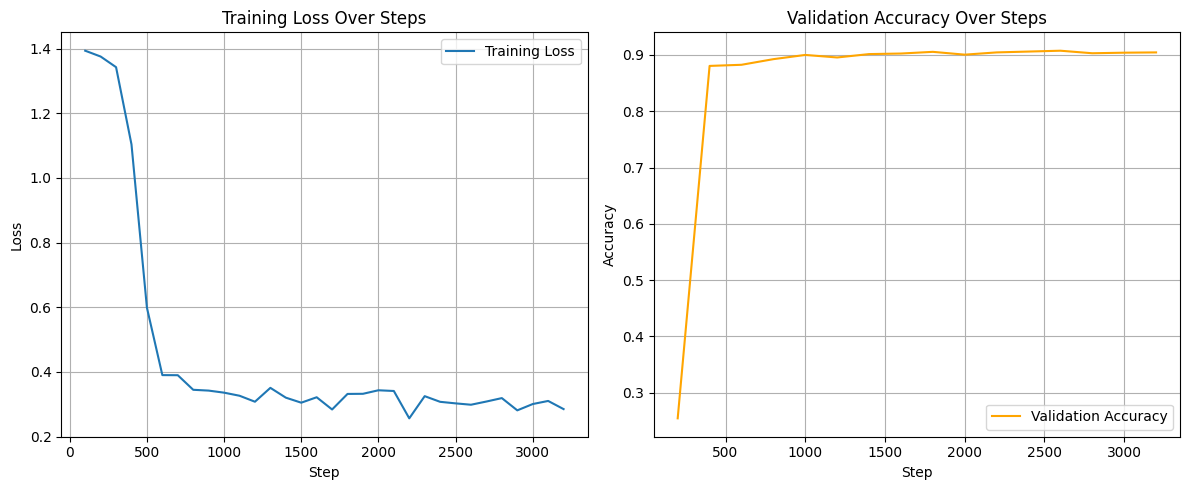

In [ ]:
training_history = trainer.state.log_history
steps, losses, eval_accs = [], [], []
for entry in training_history:
    if 'loss' in entry:
        steps.append(entry['step'])
        losses.append(entry['loss'])
    if 'eval_accuracy' in entry:
        eval_accs.append((entry['step'], entry['eval_accuracy']))

# Plotting training loss and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, losses, label='Training Loss')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
if eval_accs:
    eval_steps, eval_values = zip(*eval_accs)
    plt.plot(eval_steps, eval_values, label='Validation Accuracy', color='orange')
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Over Steps")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Evaluate
eval_results = trainer.evaluate()
print("\nEvaluation Results:", eval_results)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Evaluation Results: {'eval_loss': 0.2938327193260193, 'eval_accuracy': 0.9075, 'eval_runtime': 37.4705, 'eval_samples_per_second': 53.375, 'eval_steps_per_second': 0.854, 'epoch': 0.43389830508474575}


In [ ]:
# Test set accuracy
test_results = trainer.evaluate(eval_dataset=test_dataset)
print("Test Set Accuracy:", test_results['eval_accuracy'])

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Set Accuracy: 0.9039473684210526


In [ ]:
# Classification function for inference
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [19]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlingand of ultra-cynics, are seeing green again.


'Business'

In [ ]:
# Loading unlabeled Kaggle Test set
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [ ]:
# Predictions function for unlabelled dataset
def get_predictions(model, dataset):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, collate_fn=data_collator)

    all_preds = []
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        preds = outputs.logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().tolist())

    return all_preds

In [ ]:
time = datetime.now().strftime("%d%m%Y%H%M")
predictions = get_predictions(peft_model, test_dataset)
df_output = pd.DataFrame({"ID": range(len(predictions)), "Label": predictions})
# Save predictions to CSV for Kaggle submission
df_output.to_csv(f"inference_output_{time}.csv", index=False)
print(f"Predictions saved to inference_output_{time}.csv")

Predictions saved to inference_output_190420252057.csv
